In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

from scipy.io import wavfile
from scipy.signal import stft

import matplotlib.pyplot as plt

import librosa

from env import *
import data
import data.align
from data.transform import *
from data.transform import cepstrum

from visualization import plot_spec
from vocoder import griffin_lim

In [3]:
print(n_mfcc_align)

64


In [4]:
def zero_phase_filter():
    pass

In [5]:
def vcc2016filename(speaker=0, audio=1):
    assert 1 <= audio <= 162
    speakers = ['SF1', 'SF2', 'SF3', 'SM1', 'SM2',
                'TF1', 'TF2', 'TM1', 'TM2', 'TM3']
    return ('datasets/vcc2016/vcc2016_training/' + speakers[speaker] + '/'
            + str(100000 + audio) + '.wav')


def sound(x, rate=sr, label=''):
    from IPython.display import display, Audio, HTML
    display(HTML(
        '<style> table, th, td {border: 0px; }</style> <table><tr><td>'
        + label + '</td><td>' + Audio(x, rate=rate)._repr_html_()[3:]
        + '</td></tr></table>'
    ))

freq = None

def read_data(filename):
    global freq
    audio = data.read_audio(filename)
    freq, _, _ = signal.stft(audio, sr, nperseg=n_fft)
    sound(audio)
    return data.AudioData(filename)

dat1, dat2 = (read_data(vcc2016filename(0, 1)),
                read_data(vcc2016filename(3, 1)))

log_amp1_raw, log_amp2_raw = log_stft(dat1.amp), log_stft(dat2.amp)

aligned_list = data.align.dtw_align(
    dat1.mfcc_align, dat2.mfcc_align,
    selected_frames=(dat1.selected_frames, dat2.selected_frames)
)
indices1, indices2 = zip(*aligned_list)
log_amp1_raw, log_amp2_raw = log_amp1_raw[:, indices1], log_amp2_raw[:, indices2]

""


""


""


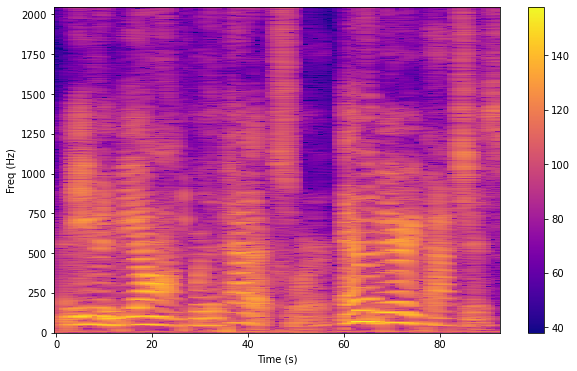

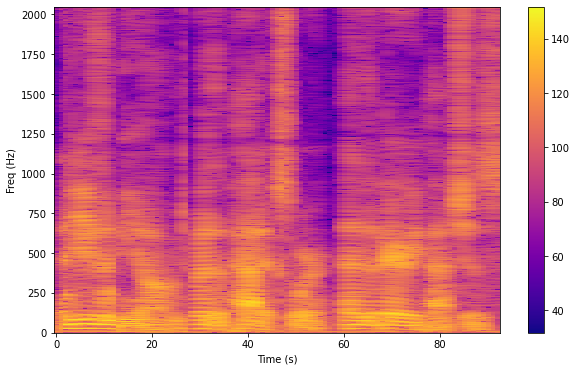

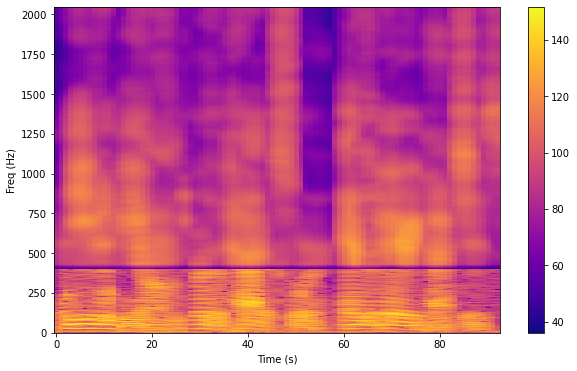

In [6]:
log_amp1, log_amp2 = log_amp1_raw.copy(), log_amp2_raw.copy()
plot_spec(log_amp1)
plot_spec(log_amp2)



recon = log_amp1.copy()
l = 400
recon[:l,:] = log_amp2[:l,:]
recon[l:,:] = mean_filter(recon[l:,:], 60)
plot_spec(recon)
sound(griffin_lim(db_to_amp(recon)))

""


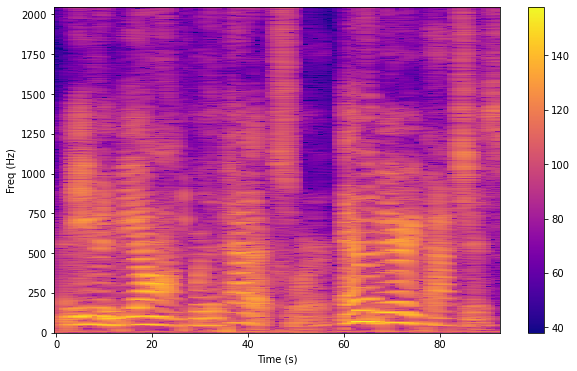

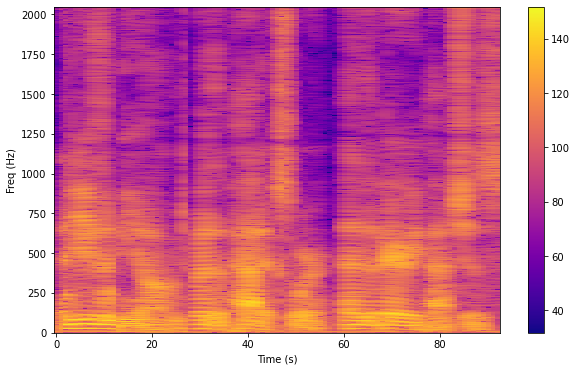

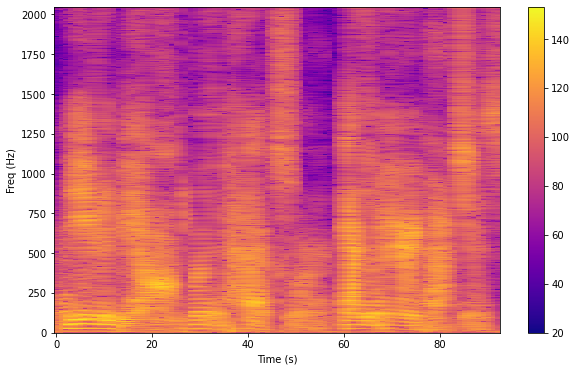

In [7]:
log_amp1, log_amp2 = log_amp1_raw.copy(), log_amp2_raw.copy()
plot_spec(log_amp1)
plot_spec(log_amp2)

filter_size = 100
lo1, lo2 = mean_filter(log_amp1, filter_size), mean_filter(log_amp2, filter_size)
hi1, hi2 = log_amp1 - lo1, log_amp2 - lo2

recon = lo1 + hi2

# recon = log_amp1.copy()
# l = 400
# recon[:l,:] = log_amp2[:l,:]
# recon[l:,:] = mean_filter(recon[l:,:], 60)
plot_spec(recon)
sound(griffin_lim(db_to_amp(recon)))

""


""


""


150
150
150
150


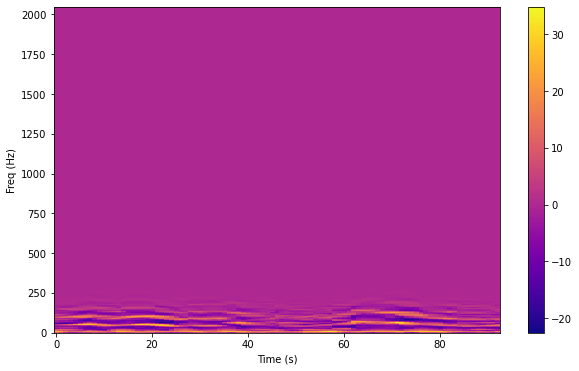

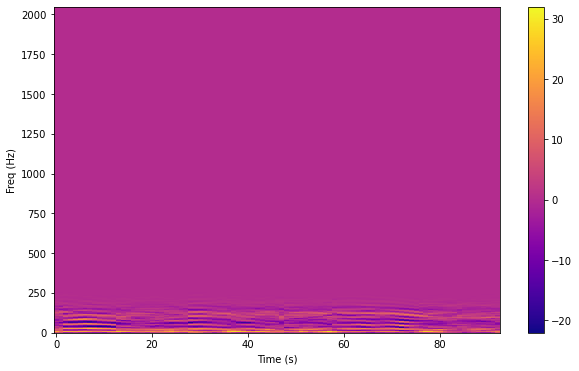

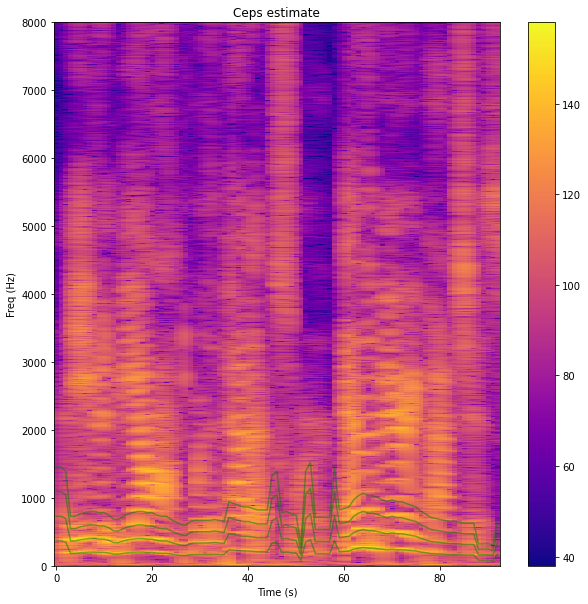

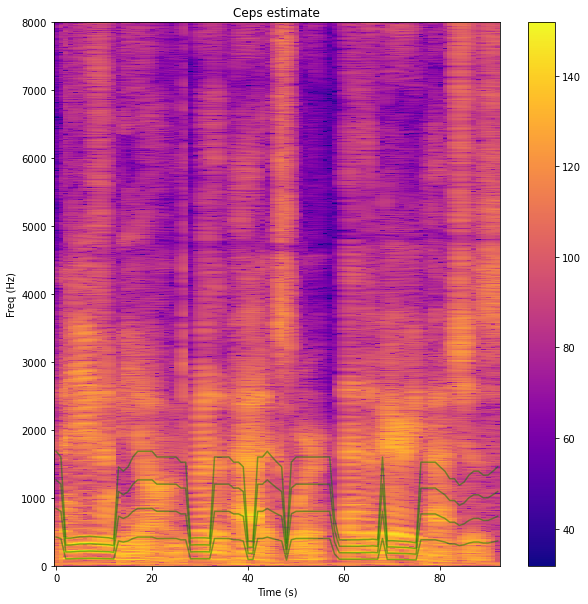

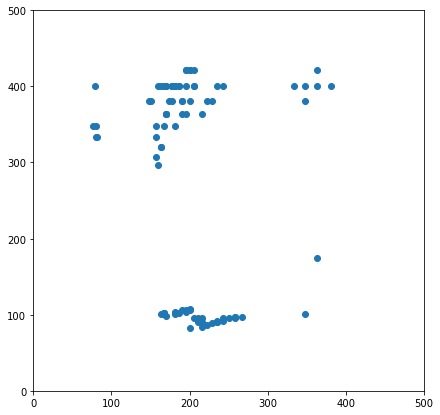

In [16]:
# regression on fundamental freq
import data
import data.transform
# from data.transform import dft_filter
log_amp1, log_amp2 = log_amp1_raw.copy(), log_amp2_raw.copy()

sound(griffin_lim(db_to_amp(log_amp1)))
sound(griffin_lim(db_to_amp(log_amp2)))
sound(griffin_lim(db_to_amp(log_amp1)+db_to_amp(log_amp2)))


filter_size = 100
lo1, hi1 = data.transform.dft_filter(log_amp1)
lo2, hi2 = data.transform.dft_filter(log_amp2)

from numpy.fft import rfft

def get_fund_freq(log_amp):
    _, hi = data.transform.dft_filter(log_amp)
    mask = 1/(1+np.e**(np.linspace(-6,80, num=frame_size)))
    mask = mask.reshape((-1, 1))
    hi = hi * mask
    plot_spec(hi)
    # filtered_ceps = cepstrum.filtered_cepstrum(log_amp, kernel_size=20)
    filtered_ceps = np.abs(rfft(hi, axis=0))
    filtered_ceps= mean_filter(filtered_ceps, kernel_size=1)
    ceps_max=np.max(filtered_ceps, axis=0)
    fundamental = np.argmax(filtered_ceps, axis=0)
    # fund_freq = freq[(frame_size / fundamental).astype(np.int8)]
    # return np.where(ceps_max>1000, sr/2/fundamental, 0)
    fund_freq = sr /2/ fundamental
    return fund_freq

def get_fund_fre1q(log_amp):
    mod_ceps = cepstrum.mod_cepstrum(log_amp)

    # _, hi = data.transform.dft_filter(log_amp)
    # plot_spec(hi)
    # # filtered_ceps = cepstrum.filtered_cepstrum(log_amp, kernel_size=20)
    #
    # filtered_ceps = np.abs(rfft(hi, axis=0))
    ceps_max=np.max(mod_ceps, axis=0)
    fundamental = np.argmax(mod_ceps, axis=0)
    # fund_freq = freq[(frame_size / fundamental).astype(np.int8)]
    # return np.where(ceps_max>1000, sr/2/fundamental, 0)
    fund_freq = freq[fundamental]
    return fund_freq

fund_freq1 = get_fund_freq(log_amp1)
fund_freq2 = get_fund_freq(log_amp2)
plot_spec(log_amp1, freq=freq, title='Ceps estimate', figure_size=(10,10))
for i in range(1, 5):
    plt.plot(np.arange(log_amp1.shape[1]),
             i*fund_freq1, c='g', alpha=0.5)
plot_spec(log_amp2, freq=freq, title='Ceps estimate', figure_size=(10,10))
for i in range(1, 5):
    plt.plot(np.arange(log_amp2.shape[1]),
             i*fund_freq2, c='g', alpha=0.5)

plt.figure(figsize=(7,7))
plt.xlim(0,  500)
plt.ylim(0, 500)
plt.scatter(fund_freq1, fund_freq2, vmin=0, vmax=500)

# recon = lo1 + hi2

# recon = log_amp1.copy()
# l = 400
# recon[:l,:] = log_amp2[:l,:]
# recon[l:,:] = mean_filter(recon[l:,:], 60)
# plot_spec(recon)
# sound(griffin_lim(db_to_amp(recon)))
#
# filtered_ceps = cepstrum.filtered_cepstrum(log_amp1, kernel_size=20)
# fundamental = np.argmax(filtered_ceps, axis=0)
# fund_freq = freq[(frame_size / fundamental).astype(np.int8)]
# # signal.resample()